In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler

In [2]:
mushroom_whole = pd.read_csv('mushroom.csv')

In [3]:
def update_cov(X,mean,weights,group):
    """a function to estimate the covariance with a new mean
    Parameter
    -------------------------------
    X : array-like
    the data with which we want to estimate the new covariance

    mean : array-like
    the new mean that doesn't correspond to the 'true mean'

    weights : arrar-like 
    the matrix of weights of the whole data

    group : int
    the group in which we want to update
    --------------------------------
    """
    sum_of_mat = np.zeros((X.shape[1],X.shape[1]))
    for i in range(X.shape[0]):
        temporal_cov = weights[i,group]*np.matmul((X[i,:]-mean).reshape((X.shape[1],1)),
                                                      (X[i,:]-mean).reshape((1,X.shape[1])))
        sum_of_mat += temporal_cov
    sum_of_weights = np.sum(weights[:,group])
    weighted_sigma = sum_of_mat/sum_of_weights
    return weighted_sigma

In [4]:
mushroom_whole_class = mushroom_whole['class'].copy()
mushroom_whole = StandardScaler().fit_transform(X=mushroom_whole.to_numpy()[:,:-1])
mushroom_whole = pd.DataFrame(mushroom_whole)
mushroom_whole['class'] = mushroom_whole_class
mushroom_data = mushroom_whole.sample(frac=0.8)
list_train = mushroom_data.index.copy()
list_test = []
for i in mushroom_whole.index:
    if i not in list_train:
        list_test.append(i)
mushroom_test = mushroom_whole.filter(items=list_test, axis=0)
mushroom_data = mushroom_data.reset_index(drop=True)
mushroom_test = mushroom_test.reset_index(drop=True)
n_samples = mushroom_data.shape[0]
n_samples_test = mushroom_test.shape[0]

In [5]:
mushroom_data['label'] = np.ones((n_samples))*99
for i in range(n_samples):
    random = bernoulli.rvs(p=3/4)
    if mushroom_data.loc[i,'class'] == 1 and random == 0:
        mushroom_data.loc[i,'label'] = 1

In [6]:
list_of_inertia = []
for i in range(1,7):
    list_of_inertia.append(KMeans(n_clusters=i).fit(X=mushroom_data.drop(['class','label'], axis=1).to_numpy()).inertia_)

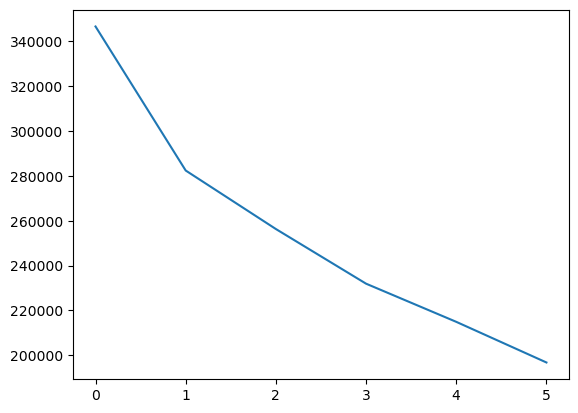

In [7]:
plt.plot(list_of_inertia)

In [8]:
mushroom_data['cluster_lab'] = KMeans(n_clusters=3).fit(X=mushroom_data.drop(['class','label'], axis=1).to_numpy()).labels_

In [9]:
fit_cluster = KMeans(n_clusters=3).fit(X=mushroom_data.drop(['class','label'], axis=1).to_numpy())

In [10]:
mushroom_data[mushroom_data['label']==1].groupby('cluster_lab').count()['label']

cluster_lab
0    2094
1    2430
2    1420
Name: label, dtype: int64

In [11]:
positive_cluster = np.where(np.array(mushroom_data[mushroom_data['label']==1].groupby('cluster_lab').count()['label']) == 
                            np.max(np.array(mushroom_data[mushroom_data['label']==1].groupby('cluster_lab').count()['label'])))[0][0]

In [12]:
positive_cluster

1

In [13]:
negative_cluster=np.where(np.array(mushroom_data[mushroom_data['label']==1].groupby('cluster_lab').count()['label']) == 
                            np.min(np.array(mushroom_data[mushroom_data['label']==1].groupby('cluster_lab').count()['label'])))[0][0]

In [14]:
negative_cluster

2

In [15]:
positive_data = mushroom_data[mushroom_data['label'] == 1]
reliable_negative = mushroom_data[mushroom_data['cluster_lab'] == negative_cluster]

In [18]:
label_1 = positive_data.drop(['class','label','cluster_lab'], axis=1).to_numpy()
label_0 = reliable_negative.drop(['class','label','cluster_lab'], axis=1).to_numpy()

In [19]:
mean_1 = np.mean(label_1,axis=0)
mean_0 = np.mean(label_0, axis=0)

In [20]:
cov_1 = np.cov(label_1, rowvar=False)
cov_0 = np.cov(label_0, rowvar=False)

In [21]:
weights = np.zeros((n_samples,2))

In [23]:
for i in range(n_samples):
    if mushroom_data.loc[i,'cluster_lab'] == negative_cluster:
        mushroom_data.loc[i,'label'] = 0

In [24]:
for group in range(2):
    for i in range(n_samples):
        if mushroom_data.loc[i,'label'] == group:
            weights[i,group] = 1

In [25]:
np.sum(weights,axis=0)

array([11674.,  4524.])

In [26]:
pi_0 = 1/2
pi_1 = 1/2

In [27]:
dict_pi = {'pi_0':pi_0,'pi_1':pi_1}

In [28]:
dict_mean = {'mean_0':mean_0,'mean_1':mean_1}
dict_cov = {'cov_0':cov_0,'cov_1':cov_1}

In [29]:
data_gmm = mushroom_data.to_numpy()[:,:8]
iterations = 10
count = 0

#to opti : put the weights to O/1 before so only one condition in the loop

while count<=iterations:
    count+=1
    for group in range(2):
        for i in range(n_samples):
            if mushroom_data.loc[i,'label'] == 99:
                x_test = data_gmm[i,:]
                numerator = dict_pi['pi_{0}'.format(group)]*multivariate_normal.pdf(x=x_test,
                                                                                    mean=dict_mean['mean_{0}'.format(group)],
                                                                                    cov=dict_cov['cov_{0}'.format(group)],allow_singular=True)
                denom = pi_0*multivariate_normal.pdf(x=x_test,mean=mean_0,cov=cov_0,allow_singular=True)+pi_1*multivariate_normal.pdf(x=x_test,mean=mean_1,cov=cov_1,allow_singular=True)
                result = numerator/denom
                weights[i,group] = result           
            elif mushroom_data.loc[i,'label'] == group:
                weights[i,group] = 1
            else:
                weights[i,group] = 0
        sum_of_weights = np.sum(weights[:,group])
        dict_pi['pi_{0}'.format(group)] = np.mean(weights[:,group])
        dict_mean['mean_{0}'.format(group)] = np.sum((data_gmm*(weights[:,group].reshape(n_samples,1))),axis=0)/sum_of_weights
        dict_cov['cov_{0}'.format(group)] = update_cov(X=data_gmm,group=group,
                                                       mean=dict_mean['mean_{0}'.format(group)],weights=weights)           
        

In [30]:
for i in range(n_samples):
    if weights[i,1] >= weights[i,0]:
        mushroom_data.loc[i,'label'] = 1
    else:
        mushroom_data.loc[i,'label'] = 0

positives = 0
true_positives = 0 
for i in range(n_samples):
    if mushroom_data.loc[i,'label'] == 1:
        positives += 1
        if mushroom_data.loc[i,'class'] == 1:
            true_positives += 1
precision_train = true_positives/positives
recall_train = true_positives/mushroom_data[mushroom_data['class'] == 1].shape[0]
f_1_train = (2*precision_train*recall_train)/(precision_train+recall_train)
weird_thing = (recall_train**2)/(positives/n_samples)

print('precision of gmm on training data is :', precision_train, '\n',
      'recall of gmm on training data is : ', recall_train, '\n', 
      'f_1 score of gmm on training data is :', f_1_train, '\n', 
      'weird estim of gmm on training data is :', weird_thing)

precision of gmm on training data is : 0.5761294630082981 
 recall of gmm on training data is :  0.7636647140629609 
 f_1 score of gmm on training data is : 0.6567721358413977 
 weird estim of gmm on training data is : 0.8015092077730026


In [31]:
correct_label = 0
for i in range(n_samples):
    if mushroom_data.loc[i,'class'] == mushroom_data.loc[i,'label']:
        correct_label += 1
print('the correct labeled points represent :', (correct_label*100)/n_samples)

the correct labeled points represent : 56.185805496437496


#### The precision is still a bit approximative but I haven't tried a 'simple' SVM or GMM on the data fully labeled 

In [35]:
weights_test = np.zeros((n_samples_test,2))
data_test = mushroom_test.to_numpy()[:,:-1]
count_test = 0
iterations_test = 0
while count_test<=iterations_test:
    count_test+=1
    for group in range(2):
        for i in range(n_samples_test):
            x_test = data_test[i,:]
            numerator = dict_pi['pi_{0}'.format(group)]*multivariate_normal.pdf(x=x_test,
                                                                                mean=dict_mean['mean_{0}'.format(group)],
                                                                                cov=dict_cov['cov_{0}'.format(group)],allow_singular=True)
            denom = pi_0*multivariate_normal.pdf(x=x_test,mean=mean_0,cov=cov_0,allow_singular=True)+pi_1*multivariate_normal.pdf(x=x_test,mean=mean_1,cov=cov_1,allow_singular=True)
            result = numerator/denom
            weights_test[i,group] = result 


In [36]:
predicted_labels = np.zeros(n_samples_test)
for i in range(n_samples_test):
    if weights_test[i,1]>=weights[i,0]:
        predicted_labels[i] = 1
    else:
        predicted_labels[i] = 0

positives_test = 0
true_positives_test = 0
for i in range(n_samples_test):
    if predicted_labels[i] == 1:
        positives_test += 1
        if mushroom_test.loc[i,'class'] == 1:
            true_positives_test += 1


precision_test = true_positives_test/positives_test
recall_test = true_positives_test/mushroom_test[mushroom_test['class'] == 1].shape[0]
f_1_score_test = (2*precision_test*recall_test)/(precision_test+recall_test)
weird_estim_test = (recall_test**2)/(positives_test/n_samples_test)
print('precision of gmm on the training set is : ', precision_test, '\n', 
      'recall of gmm on the training set is : ', recall_test, '\n', 
      'f_1 score of gmm on the training set is : ', f_1_score_test, '\n',
      'weird metric of gmm on the training set is : ', weird_estim_test )


precision of gmm on the training set is :  0.5531431456702853 
 recall of gmm on the training set is :  0.7369660275815675 
 f_1 score of gmm on the training set is :  0.6319584655321604 
 weird metric of gmm on the training set is :  0.7409096479704251
